In [1]:
from collections import namedtuple
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
# from sklearn.neighbors import KernelDensity
import colorcet as cc
from pathlib import Path
import esmlab
import scipy.stats as stats

In [2]:
model_colors = {}
# for i, m in enumerate(["cesm", "cnrm", "ipsl", "mri", "hadgem"]):
#     model_colors[m] = cc.cm.glasbey_hv(i)
for i, m in [(0, "cesm"), (1, "cnrm"), (2, "ipsl"), (3, "mri"), (6, "hadgem")]:
    model_colors[m] = cc.cm.glasbey_hv(i) 

# hard code locking to other blues, assumes CESM is first in list.
model_colors['f-lock'] = cc.cm.glasbey_hv(5)
model_colors['f-cntl'] = model_colors['f-lock']
model_colors['c-lock'] = cc.cm.glasbey_hv(8)
model_colors['c-cntl'] = model_colors['c-lock']

In [3]:
def quick_load_var(loc, var, table, model, experiment, member):
    fils = sorted(
        list(Path(loc).glob("_".join([var, table, model, experiment, member, "*.nc"])))
    )
    if len(fils) == 0:
        raise IOError("Can not find the files.")
    elif len(fils) == 1:
        ds = xr.open_dataset(fils[0])
    else:
        ds = xr.open_mfdataset(fils, combine="by_coords")
    return ds[var].compute()

In [4]:
data_loc = Path("/Volumes/Jedha/CMIP6")

In [5]:
## do these:

sims = {"cesm-amip": ("CESM2", "amip", "r1i1p1f1"),
        "cesm-amip-off": ("CESM2","amip-lwoff","r1i1p1f1"),
        "cesm-aqua": ("CESM2", "aqua-control", "r1i1p1f1"),
        "cesm-aqua-off": ("CESM2", "aqua-control-lwoff", "r1i1p1f1"),
        "ipsl-amip": ("IPSL-CM6A-LR", "amip", "r1i1p1f1"),
        "ipsl-amip-off": ("IPSL-CM6A-LR", "amip-lwoff", "r1i1p1f1"),
        "ipsl-aqua": ("IPSL-CM6A-LR", "aqua-control", "r1i1p1f1"),
        "ipsl-aqua-off": ("IPSL-CM6A-LR", "aqua-control-lwoff", "r1i1p1f1"),
        "cnrm-amip": ("CNRM-CM6-1", "amip", "r1i1p1f2"),
        "cnrm-amip-off": ("CNRM-CM6-1", "amip-lwoff", "r1i1p1f2"),
        "cnrm-aqua": ("CNRM-CM6-1", "aqua-control", "r1i1p1f2"),
        "cnrm-aqua-off": ("CNRM-CM6-1", "aqua-control-lwoff", "r1i1p1f2"),
        "mri-amip" : ("MRI-ESM2-0", "amip", "r1i1p1f1"),
        "mri-amip-off" : ("MRI-ESM2-0", "amip-lwoff", "r1i1p1f1"),
        "hadgem-amip" : ("HadGEM3-GC31-LL", "amip", "r1i1p1f3"),
        "hadgem-amip-off" : ("HadGEM3-GC31-LL", "amip-lwoff", "r5i1p1f2"),
        "hadgem-aqua" : ("HadGEM3-GC31-LL", "aqua-control", "r1i1p1f3"),
        "hadgem-aqua-off" : ("HadGEM3-GC31-LL", "aqua-control-lwoff", "r1i1p1f3")
       }


In [6]:
# for each simulation, I want to get:
# - global mean precip
# - global mean precip, ocean only
# - tropical mean precip
# - tropical mean precip, ocean only
# - tropical UNWEIGHTED mean precip, ocean only
# - 95th percentile of tropical ocean precip
# - sum of tropical ocean precip with p >= p95
# - sum of tropical ocean precip
# Define a namedtuple:
Result = namedtuple('Result', ['case', 'gavg', 'goavg', 'tavg', 'toavg', 'toavg_uw', 'p95', 'tsum', 'xsum'])


def get_pr_info(dloc, model, experiment, member):
    tropics = slice(-30,30)
    pr = quick_load_var(data_loc, "pr", "day", model, experiment, member)
    lat = pr['lat']
    wgt = np.cos(np.radians(lat))
    gavg = esmlab.weighted_mean(pr.mean(dim=('time','lon')), dim=["lat"], weights=wgt).item()
    tavg = esmlab.weighted_mean(pr.sel(lat=tropics).mean(dim=('time','lon')), dim=["lat"], weights=wgt.sel(lat=tropics)).item()
    if 'amip' in c:
        land = quick_load_var(data_loc, "sftlf", "fx", model, experiment, member)
        land_trop = land.sel(lat=tropics)
        msk, _ = xr.broadcast(land, pr)
        pr = pr.where(msk <= 0)
        goavg = esmlab.weighted_mean(pr.mean(dim=('time','lon')), dim=["lat"], weights=wgt).item()
        toavg = esmlab.weighted_mean(pr.sel(lat=tropics).mean(dim=('time','lon')), dim=["lat"], weights=wgt.sel(lat=tropics)).item()
    else:
        goavg = gavg
        toavg = tavg
    ptrop = pr.sel(lat=tropics)
    toavg_uw = ptrop.mean().item()
    p95 = np.nanquantile(ptrop.values.flatten(), 0.95)
    tsum = np.nansum(ptrop.values.flatten())
    xsum = np.nansum(ptrop.where(ptrop>=p95).values.flatten())
    return Result("_".join([model,experiment,member]), gavg, goavg, tavg, toavg, toavg_uw, p95, tsum, xsum)


R = {}
for c in sims:
    print(f"working on {c}")
    R[c] = get_pr_info(data_loc, *sims[c])

R

working on cesm-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cesm-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cesm-aqua


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


working on cesm-aqua-off
working on ipsl-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on ipsl-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on ipsl-aqua
working on ipsl-aqua-off
working on cnrm-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cnrm-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on cnrm-aqua
working on cnrm-aqua-off
working on mri-amip


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on mri-amip-off


/Users/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


working on hadgem-amip
working on hadgem-amip-off
working on hadgem-aqua
working on hadgem-aqua-off


{'cesm-amip': Result(case='CESM2_amip_r1i1p1f1', gavg=3.335214581376049e-05, goavg=3.510287202056346e-05, tavg=3.972882151858157e-05, toavg=3.810103323664371e-05, toavg_uw=3.799505066126585e-05, p95=0.00016276335591101053, tsum=11771.402, xsum=4660.9253),
 'cesm-amip-off': Result(case='CESM2_amip-lwoff_r1i1p1f1', gavg=3.1898189656810654e-05, goavg=3.6691127216183814e-05, tavg=4.0337348532039076e-05, toavg=4.451005603576896e-05, toavg_uw=4.439959229785018e-05, p95=0.00017272413679165783, tsum=7618.756, xsum=2492.2173),
 'cesm-aqua': Result(case='CESM2_aqua-control_r1i1p1f1', gavg=3.8199234236945356e-05, goavg=3.8199234236945356e-05, tavg=4.669582324942678e-05, toavg=4.669582324942678e-05, toavg_uw=4.54123510280624e-05, p95=0.00019911886047339054, tsum=3056.0347, xsum=1136.4103),
 'cesm-aqua-off': Result(case='CESM2_aqua-control-lwoff_r1i1p1f1', gavg=3.29666995469341e-05, goavg=3.29666995469341e-05, tavg=4.349748845682736e-05, toavg=4.349748845682736e-05, toavg_uw=4.274130697012879e-05, 

In [7]:
# Add the locking results:
variable = "PRECT"
cases = {
    'f-lock': '/Volumes/Samsung_T5/F1850JJB_c201_CLOCK.cam.h2.ncrcat.PRECT.nc',
    'f-cntl': '/Volumes/Samsung_T5/F1850JJB_c201_CTL.cam.h2.ncrcat.PRECT.nc',
    'c-lock': '/Volumes/Samsung_T5/B1850_c201_CLOCK/daily/B1850_c201_CLOCK.cam.h2.ncrcat.PRECT.nc',
    'c-cntl': '/Volumes/Samsung_T5/B1850_c201_CTL/daily/B1850_c201_CTL.cam.h2.ncrcat.PRECT.nc'}

case_names = {'f-lock': 'F1850JJB_c201_CLOCK',
    'f-cntl': 'F1850JJB_c201_CTL',
    'c-lock': 'B1850_c201_CLOCK',
    'c-cntl': 'B1850_c201_CTL'}

# f-cntl ntime = 9126
# f-lock ntime = 9126
# c-cntl ntime = 10982
# c-lock ntime = 9491


# LAND
land_file = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")
LAND = land_file['LANDFRAC'].squeeze()

def get_cesm_pr_info(fil, experiment, land=None):
    tropics = slice(-30,30)
    pr_ds = xr.open_dataset(fil)
    pr = pr_ds['PRECT']*1000. # converts to same units as CMIP6 pr
    lat = pr['lat']
    wgt = np.cos(np.radians(lat))
    gavg = esmlab.weighted_mean(pr.mean(dim=('time','lon')), dim=["lat"], weights=wgt).item()
    tavg = esmlab.weighted_mean(pr.sel(lat=tropics).mean(dim=('time','lon')), dim=["lat"], weights=wgt.sel(lat=tropics)).item()
    if land is not None:
        land_trop = land.sel(lat=tropics)
        msk, _ = xr.broadcast(land, pr)
        pr = pr.where(msk <= 0)
        goavg = esmlab.weighted_mean(pr.mean(dim=('time','lon')), dim=["lat"], weights=wgt).item()
        toavg = esmlab.weighted_mean(pr.sel(lat=tropics).mean(dim=('time','lon')), dim=["lat"], weights=wgt.sel(lat=tropics)).item()
    else:
        goavg = gavg
        toavg = tavg
    ptrop = pr.sel(lat=tropics)
    toavg_uw = ptrop.mean().item()
    p95 = np.nanquantile(ptrop.values.flatten(), 0.95)
    tsum = np.nansum(ptrop.values.flatten())
    xsum = np.nansum(ptrop.where(ptrop>=p95).values.flatten())
    return Result(experiment, gavg, goavg, tavg, toavg, toavg_uw, p95, tsum, xsum)

for c in cases:
    print(c)
    R[c] = get_cesm_pr_info(cases[c], c, land=LAND)


f-lock
f-cntl
c-lock
c-cntl


In [8]:

# ensure correct order:
order = ['f-cntl', 'f-lock', 'c-cntl', 'c-lock',
'cesm-amip',
'cesm-amip-off',
'cesm-aqua',
'cesm-aqua-off',
'cnrm-amip',
'cnrm-amip-off',
'cnrm-aqua',
'cnrm-aqua-off',
'hadgem-amip', 'hadgem-amip-off', 'hadgem-aqua', 'hadgem-aqua-off',
'ipsl-amip',
'ipsl-amip-off',
'ipsl-aqua',
'ipsl-aqua-off',
'mri-amip',
'mri-amip-off',
]
RR = {r:R[r] for r in order}
RR

{'f-cntl': Result(case='f-cntl', gavg=3.399501545619739e-05, goavg=3.690918554878124e-05, tavg=4.046486323974127e-05, toavg=4.059613737778296e-05, toavg_uw=4.053293014294468e-05, p95=0.00018806360603775777, tsum=4830.2, xsum=2091.629),
 'f-lock': Result(case='f-lock', gavg=3.429638060268712e-05, goavg=3.662185058473464e-05, tavg=4.05637034288092e-05, toavg=3.9702983240719116e-05, toavg_uw=3.965625001001172e-05, p95=0.0001827990534366106, tsum=4725.7285, xsum=1936.4758),
 'c-cntl': Result(case='c-cntl', gavg=3.38783865575725e-05, goavg=3.676528283864096e-05, tavg=4.031647605733698e-05, toavg=4.040782806078191e-05, toavg_uw=4.034433368360624e-05, p95=0.00018834964066627435, tsum=5785.4966, xsum=2481.867),
 'c-lock': Result(case='c-lock', gavg=3.421870559067287e-05, goavg=3.6597212433264605e-05, tavg=4.038255076461343e-05, toavg=3.968286160013134e-05, toavg_uw=3.960659523727372e-05, p95=0.0001865355734480545, tsum=4908.583, xsum=2048.8516),
 'cesm-amip': Result(case='CESM2_amip_r1i1p1f1',

f-cntl f-cntl
f-lock f-lock
c-cntl c-cntl
c-lock c-lock
cesm-amip cesm
cesm-amip-off cesm
cesm-aqua cesm
cesm-aqua-off cesm
cnrm-amip cnrm
cnrm-amip-off cnrm
cnrm-aqua cnrm
cnrm-aqua-off cnrm
hadgem-amip hadgem
hadgem-amip-off hadgem
hadgem-aqua hadgem
hadgem-aqua-off hadgem
ipsl-amip ipsl
ipsl-amip-off ipsl
ipsl-aqua ipsl
ipsl-aqua-off ipsl
mri-amip mri
mri-amip-off mri


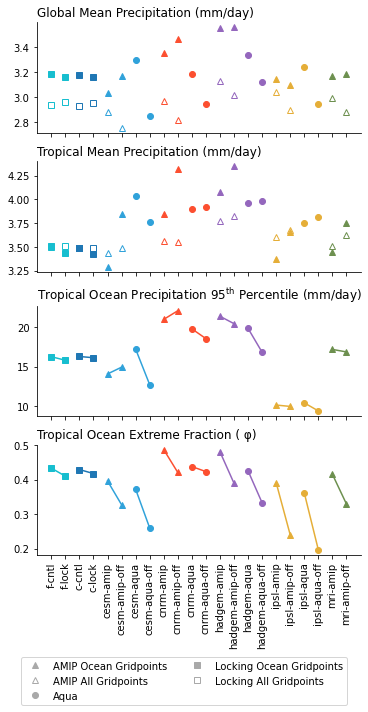

In [25]:
# Now we have R which can be used to make a summary plot:
# R is a dict of namedtuples ... so to access: R[case].field


fig, ax = plt.subplots(figsize=(5,9), nrows=4, sharex=True, constrained_layout=True)
xval = 1
for i, c in enumerate(RR):
    pieces = c.split("-")
    if c not in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']:
        model = pieces[0]
    else:
        model = c
    if ('amip' in c):
        m = '^'
    elif (c in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']):
        m = "s"
    else:
        m = 'o'
    print(c, model)
    mfill = 'full'
    mafill = 'none'

    if ('amip' in c) or (c in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']):
        ax[0].plot(xval, RR[c].gavg*86400.0, marker=m, color=model_colors[model], fillstyle=mafill)
        ax[1].plot(xval, RR[c].tavg*86400.0, marker=m, color=model_colors[model], fillstyle=mafill)
    ax[0].plot(xval, RR[c].goavg*86400.0, marker=m, color=model_colors[model], fillstyle=mfill)
    ax[1].plot(xval, RR[c].toavg*86400.0, marker=m, color=model_colors[model], fillstyle=mfill)
    #ax[1].plot(xval, RR[c].toavg_uw*86400.0, marker='*', color=model_colors[model], fillstyle=mfill)
    ax[2].plot(xval, RR[c].p95*86400.0, marker=m, fillstyle=mfill, color=model_colors[model])
    ax[3].plot(xval, RR[c].xsum/R[c].tsum, marker=m, fillstyle=mfill, color=model_colors[model])
    # ADD A LINE CONNECTING PAIRS
    if i % 2 == 1:
        ax[2].plot( [xval-1, xval], [RR[order[i-1]].p95*86400.0, RR[order[i]].p95*86400.0], color=model_colors[model])
        ax[3].plot( [xval-1, xval], [RR[order[i-1]].xsum/RR[order[i-1]].tsum, RR[order[i]].xsum/RR[order[i]].tsum], color=model_colors[model])
    xval += 1

ax[0].set_title("Global Mean Precipitation (mm/day)", loc='left')
ax[1].set_title("Tropical Mean Precipitation (mm/day)", loc='left')
ax[2].set_title("Tropical Ocean Precipitation 95$^{\mathrm{th}}$ Percentile (mm/day)", loc='left')
ax[3].set_title("Tropical Ocean Extreme Fraction ( \u03c6)", loc='left')
ax[-1].set_xticks(np.arange(1, len(RR)+1))
ax[-1].set_xticklabels(RR.keys(), rotation=90)

[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]

#
from matplotlib.lines import Line2D
legend_elements_last = [Line2D([0], [0], marker="^", linestyle="None", fillstyle='full', color="darkgray", label='AMIP Ocean Gridpoints'),
                        Line2D([0], [0], marker="^", linestyle="None", fillstyle='none', color="darkgray", label='AMIP All Gridpoints'),            
                        Line2D([0], [0], marker="o", linestyle="None", fillstyle='full', color="darkgray", label='Aqua'),
                        Line2D([0], [0], marker="s", linestyle="None", fillstyle='full', color="darkgray", label='Locking Ocean Gridpoints'),
                        Line2D([0], [0], marker="s", linestyle="None", fillstyle='none', color="darkgray", label='Locking All Gridpoints'),
                  ]

fig.legend(handles=legend_elements_last, loc='lower center', bbox_to_anchor=(.5, -0.09), frameon=True, ncol=2)

plotname = Path("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/summary_stats_v3.pdf")
if not plotname.exists():
    fig.savefig(plotname, bbox_inches='tight')

[('f-cntl', 'f-lock'), ('c-cntl', 'c-lock'), ('cesm-amip', 'cesm-amip-off'), ('cesm-aqua', 'cesm-aqua-off'), ('cnrm-amip', 'cnrm-amip-off'), ('cnrm-aqua', 'cnrm-aqua-off'), ('hadgem-amip', 'hadgem-amip-off'), ('hadgem-aqua', 'hadgem-aqua-off'), ('ipsl-amip', 'ipsl-amip-off'), ('ipsl-aqua', 'ipsl-aqua-off'), ('mri-amip', 'mri-amip-off')]
Model is f-cntl : Compare RR[f-lock] to RR[f-cntl] ... deltaMean = -0.02200096350921898
Model is c-cntl : Compare RR[c-lock] to RR[c-cntl] ... deltaMean = -0.017941238008637065
Model is cesm : Compare RR[cesm-amip-off] to RR[cesm-amip] ... deltaMean = 0.16821125976608337
Model is cesm : Compare RR[cesm-aqua-off] to RR[cesm-aqua] ... deltaMean = -0.0684929522607502
Model is cnrm : Compare RR[cnrm-amip-off] to RR[cnrm-amip] ... deltaMean = 0.12588251498188904
Model is cnrm : Compare RR[cnrm-aqua-off] to RR[cnrm-aqua] ... deltaMean = 0.0032487218798287077
Model is hadgem : Compare RR[hadgem-amip-off] to RR[hadgem-amip] ... deltaMean = 0.06522749117296536
M

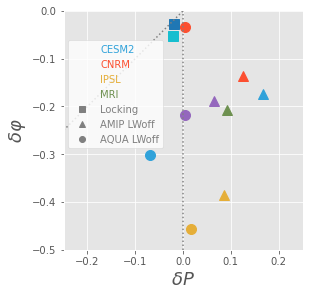

In [25]:
# this just gets the pairs of simulations to form "experiments"

epair = []
for i, c in enumerate(RR):
    m = RR[c].case[0:4]
    if i%2 == 1:
        epair.append((prior_case, c))
    else:
        prior_case = c
print(epair)
# now for each experiment, I want to get:
# tavg[1]-tavg[0] / tavg[0]
# xfrac[1]-xfrac[0]/xfrac[0]
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(nrows=1, sharex=True, constrained_layout=True)
    xval = 1
    for c in epair:
        pieces = c[0].split("-")
        if c[0] not in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']:
            model = pieces[0]
        else:
            model = c[0]
        if 'aqua' in c[0]:
            m = 'o'
        elif c[0] in ['f-cntl', 'f-lock', 'c-cntl', 'c-lock']:
            m = "s"
        else:
            m = '^'
        mfill = 'full'
        mafill = 'none'
        delta_mean = ((RR[c[1]].toavg - RR[c[0]].toavg)/RR[c[0]].toavg)
        xfrac0 = RR[c[0]].xsum/RR[c[0]].tsum
        xfrac1 = RR[c[1]].xsum/RR[c[1]].tsum
        delta_xfrac = (xfrac1-xfrac0)/xfrac0
        print(f"Model is {model} : Compare RR[{c[1]}] to RR[{c[0]}] ... deltaMean = {delta_mean}")


    #     ax[0].plot(xval, delta_mean, marker=m, color='tab:blue', fillstyle=mafill)
    #     ax[1].plot(xval, delta_xfrac, marker=m, color='tab:blue', fillstyle=mafill)
    #     xval += 1
        ax.plot(delta_mean, delta_xfrac, marker=m, color=model_colors[model], fillstyle=mfill, markersize=10)

    ax.plot([-1, 1], [-1, 1], linestyle=":", color='gray')
    ax.set_xlabel("$\u03b4 P$", loc='center', fontsize=18)
    ax.set_ylabel("$\u03b4 \u03c6$", loc='center', fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([-0.25, 0.25])
    ax.set_ylim([-0.5, 0.])
    ax.set_aspect('equal')


    from matplotlib.lines import Line2D

    legend_elements = [Line2D([0], [0], marker="None", linestyle="None", color=model_colors['cesm'], label='CESM2'),
                       Line2D([0], [0], marker="None", linestyle="None", color=model_colors['cnrm'], label='CNRM'),
                       Line2D([0], [0], marker="None", linestyle="None", color=model_colors['ipsl'], label='IPSL'),
                       Line2D([0], [0], marker="None", linestyle="None", color=model_colors['mri'], label='MRI'),
                       Line2D([0], [0], marker='s', color='gray', linestyle="None", label='Locking'),
                       Line2D([0], [0], marker='^', color='gray', linestyle="None", label='AMIP LWoff'),
                       Line2D([0], [0], marker='o', color='gray', linestyle="None", label='AQUA LWoff'),

                      ]

    ax.legend(handles=legend_elements, loc=(0.02, 0.425), labelcolor='linecolor', facecolor=[1, 1, 1, 0])
    ax.axvline(0.0, linestyle=':', color='gray')
    plotname = Path("/Users/brianpm/Dropbox/Manuscripts/M_cre_pex/mean_versus_extreme_v3.pdf")
    if not plotname.exists():
        fig.savefig(plotname, bbox_inches='tight')

In [129]:
print(RR['cesm-aqua'].tavg)
print(RR['cesm-aqua-off'].tavg)
print((RR['cesm-aqua-off'].tavg - RR['cesm-aqua'].tavg)/RR['cesm-aqua'].tavg  )


print(RR['cnrm-amip'].toavg)
print(RR['cnrm-amip-off'].toavg)
print((RR['cnrm-amip-off'].toavg - RR['cnrm-amip'].toavg)/RR['cnrm-amip'].toavg  )


4.669582324942678e-05
4.349748845682736e-05
-0.0684929522607502
4.4454349775372726e-05
5.005037512698122e-05
0.12588251498188904


In [9]:
# for the amip runs, we need the land fraction:
land = {}
for s in sims:
    if 'amip' in s:
        land[s] = quick_load_var(data_loc, "sftlf", "fx", *sims[s])

/Users/brianpm/anaconda3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [10]:
# remove land points from the amip runs:
for c in pr:
    if 'amip' in c:
        pr[c] = pr[c].where(land[c] <= 0)

In [14]:
def get_tropics_quantiles(da, threshold=None, q=0.99):
    da_tropics = da.sel(lat=slice(-30, 30))  # SHOULD BE ADJUSTABLE
    da_tropics_val = np.nanquantile(da_tropics, q)
    if threshold is not None:
        da_climo = da.mean(dim="time")
        da_process = np.where(
            (da_climo >= threshold).sel(lat=slice(-30, 30)).broadcast_like(da_tropics),
            da_tropics,
            np.nan,
        )
        da_threshold_val = np.nanquantile(da_process, q)
        print(
            f"Compare the tropics region ({da_tropics_val}) to the rainy tropics ({da_threshold_val})"
        )
        return da_threshold_val
    else:
        print(f"Quantile value: {da_tropics_val}")
        return da_tropics_val


def conf_interval(data_series, **kwargs):
    """
    Calculate the confidence interval for the data distribution under the assumptions that it can be calculated using \
    a student-t distribution.
    
    This function expects just a simple series. To apply to an array, we will need to adjust.
    
    :return conf_int: confidence interval, to apply around mean value
    """
    if 'confidence_level' in kwargs and (kwargs['confidence_level'] is not None):
        confidence_level = kwargs["confidence_level"]
    else:
        confidence_level = 0.95
        
    n = len(data_series)
    mean = np.mean(data_series)
    # Allow a known "population standard deviation" to be passed in.
    if 'known_std' in kwargs:
        sem = kwargs['known_std'] / np.sqrt(n)
    else:
        sem = stats.sem(data_series)
    
    # The population standard deviation will be estimated by the sample standard deviation.
    # Therefore Students t distribution is used as the critical value:
    # confidence level: C
    # degrees of freedom = (N - 1)
    # critical value t* = t_α(r) where r is dof (N-1) and α = (1 - C)/2
    # This follows the same form as Forster et al. 2016:
    # CI = t_value * SE
    # with SE = σ / sqrt[N]
    conf_int = sem * stats.t.ppf((1 + confidence_level) / 2, n - 1)

    # If you wanted to give the actual interval, it's just around the mean:
    # start = mean - conf_int
    # end = mean + conf_int

    return conf_int


def report_global_mean_with_ci(arr, doprint=False, confidence_level=None):
    """Calculate the global average and confidence interval for DataArray arr."""
    wgt = np.cos(np.radians(arr['lat']))
    w, _ = xr.broadcast(wgt, arr)
    global_average = esmlab.weighted_mean(arr, dim=["lat","lon"], weights=w)
    ci = conf_interval(global_average, **{"confidence_level":confidence_level})
    if doprint:
        print(f"The mean (95% ci): {global_average.mean().values.item()} \u00B1 {ci}")
    return global_average, ci

In [15]:
# get the 99th percentile of precipitation for tropical oceans
pr99 = {}
prAV = {}
prAVci = {}
for c in pr:
    pr99[c] = get_tropics_quantiles(pr[c])
    prAV[c], prAVci[c] = report_global_mean_with_ci(pr[c])

Quantile value: 0.0003849748443462888
Quantile value: 0.0003567487851250904
Quantile value: 0.00042201049131108427
Quantile value: 0.00026625057216733694
Quantile value: 0.00042169346357695406
Quantile value: 0.00023998573160497524
Quantile value: 0.00044758025964256433
Quantile value: 0.0001830892966245307
Quantile value: 0.0005445090576540693
Quantile value: 0.000518587381811814
Quantile value: 0.0004815489955944949
Quantile value: 0.00047797238366911266


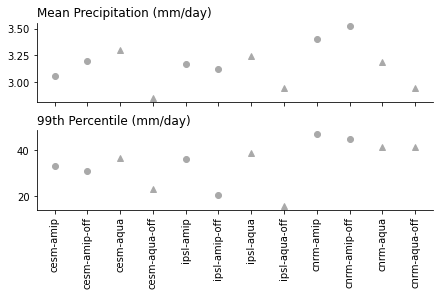

In [37]:
fig, ax = plt.subplots(nrows=2, sharex=True, constrained_layout=True)
xval = 1
for c in pr99:
    if 'amip' in c:
        m = 'o'
    else:
        m = '^'
    ax[0].plot(xval, prAV[c].mean()*86400.0, marker=m, color='darkgray')
    ax[1].plot(xval, pr99[c].mean()*86400.0, marker=m, color='darkgray')
    xval += 1

ax[0].set_title("Mean Precipitation (mm/day)", loc='left')
ax[1].set_title("99th Percentile (mm/day)", loc='left')
ax[1].set_xticks(np.arange(1, len(pr99)+1))
ax[1].set_xticklabels(pr99.keys(), rotation=90)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

In [36]:
[prAVci[c]*86400. for c in prAVci]

[0.0022061409212938516,
 0.0028942716559749036,
 0.004375811522960663,
 0.0035248446633134273,
 0.002688452406247731,
 0.002457532420799608,
 0.0035701220627936017,
 0.002981181726090687,
 0.0031770461478454336,
 0.0029570117492605436,
 0.004094379932565495,
 0.0037504784400485443]

In [ ]:
MODEL & Simulation               & [N_events]   & N_total    & [Duration]  & [Size]      & [Size_max]    Intensity //
IPSL  & aqua-control             & 20.60 ± 3.72 & 43432.00,  & 1.88 ± 1.62 & 2.40 ± 1.89 & 3.15 ± 3.24  & 38.67093334198003 //
IPSL  & aqua-control-lwoff       & 15.42 ± 3.54 & 33228.00,  & 1.84 ± 1.69 & 2.59 ± 2.82 & 3.59 ± 5.12  & 15.818915185928397 //
CNRM-CM6-1 & aqua-control        & 14.55 ± 3.15 & 33565.00,  & 1.58 ± 1.77 & 4.36 ± 4.33 & 5.54 ± 7.26  & 41.60583381652839 //
CNRM-CM6-1 & aqua-control-lwoff  & 12.74 ± 2.93 & 33339.00,  & 1.40 ± 1.21 & 5.12 ± 5.96 & 6.05 ± 8.43  & 41.29681282043464 //
CESM2 & aqua-control             & 13.66 ± 3.37 & 29816.00,  & 1.67 ± 1.95 & 6.73 ± 7.95 & 8.91 ± 14.11 & 36.46170570373533 //
CESM2 & aqua-control-lwoff       & 17.30 ± 3.37 & 35752.00,  & 1.77 ± 1.63 & 7.04 ± 7.40 & 9.49 ± 12.45 & 23.00404930114746 //
CNRM-CM6-1 & amip                & 12.08 ± 2.90 & 89594.00,  & 1.77 ± 2.06 & 3.49 ± 3.59 & 4.54 ± 6.21  & 47.04558120727552 //
CNRM-CM6-1 & amip-lwoff          & 12.48 ± 3.06 & 106396.00, & 1.54 ± 2.03 & 3.69 ± 3.81 & 4.49 ± 5.85  & 44.80594955444349 //
IPSL-CM6A-LR &  amip             & 13.44 ± 3.51 & 79114.00,  & 2.42 ± 2.97 & 2.19 ± 1.84 & 2.99 ± 3.41  & 36.43431427001923 //
IPSL-CM6A-LR & amip-lwoff        & 12.61 ± 3.74 & 81788.00,  & 2.03 ± 2.18 & 2.14 ± 2.30 & 2.92 ± 4.28  & 20.73476715087895 //
CESM2 & amip                     & 13.81 ± 3.28 & 175658.00, & 1.87 ± 1.99 & 5.45 ± 6.14 & 7.54 ± 10.98 & 33.26182556152344 //
CESM2 & amip-lwoff               & 12.34 ± 3.15 & 91516.00,  & 1.77 ± 2.00 & 5.88 ± 6.83 & 7.97 ± 12.27 & 30.823095607757466


Text(0.5, 1.0, 'Average Number')

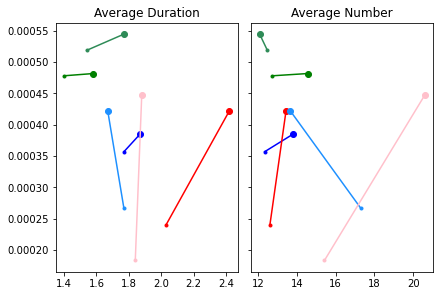

In [45]:
# what about stick diagram with yaxis being 99th percentile pr and xaxis being any of these custering metrics
epairs = (("cesm-amip", "cesm-amip-off"), ("ipsl-amip", "ipsl-amip-off"), ("cnrm-amip", "cnrm-amip-off"), ("cesm-aqua", "cesm-aqua-off"), ("ipsl-aqua", "ipsl-aqua-off"), ("cnrm-aqua", "cnrm-aqua-off"))
avg_n = {"cesm-amip": 13.81,
        "cesm-amip-off": 12.34,
        "cesm-aqua": 13.66,
        "cesm-aqua-off": 17.30,
        "ipsl-amip": 13.44,
        "ipsl-amip-off": 12.61,
        "ipsl-aqua": 20.60,
        "ipsl-aqua-off": 15.42,
        "cnrm-amip": 12.08,
        "cnrm-amip-off": 12.48,
        "cnrm-aqua": 14.55,
        "cnrm-aqua-off": 12.74,
       }

avg_d = {"cesm-amip": 1.87,
        "cesm-amip-off": 1.77,
        "cesm-aqua": 1.67,
        "cesm-aqua-off": 1.77,
        "ipsl-amip": 2.42,
        "ipsl-amip-off": 2.03,
        "ipsl-aqua": 1.88,
        "ipsl-aqua-off": 1.84,
        "cnrm-amip": 1.77,
        "cnrm-amip-off": 1.54,
        "cnrm-aqua": 1.58,
        "cnrm-aqua-off": 1.40,
       }

mclr = {"cesm-amip": 'blue',
        "cesm-amip-off": 'blue',
        "cesm-aqua": 'dodgerblue',
        "cesm-aqua-off": 'dodgerblue',
        "ipsl-amip": 'red',
        "ipsl-amip-off": 'red',
        "ipsl-aqua": 'pink',
        "ipsl-aqua-off": 'pink',
        "cnrm-amip": 'seagreen',
        "cnrm-amip-off": 'seagreen',
        "cnrm-aqua": 'green',
        "cnrm-aqua-off": 'green',
       }



fig, ax = plt.subplots(ncols=2, constrained_layout=True, sharey=True)
for p in epairs:
    ax[0].plot([avg_d[p[0]], avg_d[p[1]]], [pr99[p[0]], pr99[p[1]]], color=mclr[p[0]])
    ax[0].plot(avg_d[p[0]], pr99[p[0]], marker='o', color=mclr[p[0]])
    ax[0].plot(avg_d[p[1]], pr99[p[1]], marker='.', color=mclr[p[0]])
    ax[1].plot([avg_n[p[0]], avg_n[p[1]]], [pr99[p[0]], pr99[p[1]]], color=mclr[p[0]])
    ax[1].plot(avg_n[p[0]], pr99[p[0]], marker='o', color=mclr[p[0]])
    ax[1].plot(avg_n[p[1]], pr99[p[1]], marker='.', color=mclr[p[0]])
ax[0].set_title("Average Duration")
ax[1].set_title("Average Number")

In [9]:
np.nansum([np.nan, 2, 2, 2])

6.0

In [136]:
"PrEcpi".casefold()

'precpi'

In [14]:
for i, r in enumerate(RR):
    print(i,r)

0 f-cntl
1 f-lock
2 c-cntl
3 c-lock
4 cesm-amip
5 cesm-amip-off
6 cesm-aqua
7 cesm-aqua-off
8 cnrm-amip
9 cnrm-amip-off
10 cnrm-aqua
11 cnrm-aqua-off
12 hadgem-amip
13 hadgem-amip-off
14 hadgem-aqua
15 hadgem-aqua-off
16 ipsl-amip
17 ipsl-amip-off
18 ipsl-aqua
19 ipsl-aqua-off
20 mri-amip
21 mri-amip-off


In [19]:
-1 % 2

1